In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import dctn, idctn, dct, idct
from scipy.interpolate import interp1d

import time
import ot

from tqdm import tqdm

from typing import Union

In [2]:
def _direct_c_transform(phi: np.ndarray, cost: np.ndarray) -> np.ndarray:
    """
    Perform a direct c-transform operation on the given cost matrix adjusted by vector phi.

    This function calculates the c-transform of a cost matrix and a vector phi.
    It computes the minimum value across rows of the element-wise subtraction between
    cost matrix and phi vector, treating phi as a bias.

    Parameters:
    - phi (np.ndarray): A vector that represents potential values.
    - cost (np.ndarray): A cost matrix.

    Returns:
    - np.ndarray: The transformed vector resulting from the direct c-transform computation.
    """
    # transform = (cost - phi).min(axis=1)
    transform = (cost - phi).max(axis=1)
    return transform


def ctransform(phi: np.ndarray, cost: Union[np.ndarray, str]) -> np.ndarray:
    """
    Computes the c-transform of a vector phi with respect to a cost matrix or handles
    alternative string-based methods (not implemented).

    Parameters:
    - phi (np.ndarray): A vector representing potential values.
    - cost (Union[np.ndarray, str]): Either a numpy array representing the cost matrix or a
      string indicating the method to be used for an optimized c-transform.

    Returns:
    - np.ndarray: The result of the c-transform calculation.

    Raises:
    - NotImplementedError: If the cost is specified as a string indicating an unimplemented method.
    - TypeError: If the cost parameter is neither a numpy array nor a string.
    """
    if isinstance(cost, np.ndarray):
        return _direct_c_transform(phi, cost)
    elif isinstance(cost, str):
        raise NotImplementedError(
            'optimized ctransform has not been implemented')
    else:
        raise TypeError('cost must be either a numpy array or a string')


In [3]:
def _map_T_quadratic_cost(phi: np.ndarray, x: np.ndarray, C: np.ndarray) -> np.ndarray:
    # Note: currently, this works only for quadratic cost with given matrix C
    # this is due to unfinished ctransform function
    dx = x[1] - x[0]
    return np.gradient(
        ctransform(phi, cost=C),
        dx,  # data is evenly spaced. TODO: change later to a better way?
    )


def map_T(phi: np.ndarray, cost: Union[np.ndarray, str], X: np.ndarray, C: np.ndarray = None) -> np.ndarray:
    """Calculates the map T of a function phi given a cost type, using domains X and Y."""

    # Handling string type cost function
    if isinstance(cost, str):
        if cost == 'quadratic':
            return _map_T_quadratic_cost(phi, X, C)
        else:
            raise NotImplementedError(
                f"Not implemented for cost type '{cost}'")

    # Handling numpy array type cost function (currently not implemented)
    elif isinstance(cost, np.ndarray):
        raise NotImplementedError("Matrix cost types are not implemented")

    # Handling invalid cost type
    else:
        raise TypeError("Cost must be either a string or a numpy array")


In [193]:
def sampling_pushforward_1d(mu, xMap, xs):
    rho = np.zeros_like(mu)
    n = xs.shape[0]

    for j in range(n):
        mass = mu[j]
        if mass > 0:
            xStretch = abs(xMap[min(j + 1, n - 1)] - xMap[j])
            xSamples = max(int(n * xStretch), 1)
            factor = 1.0 / xSamples

            for k in range(xSamples):
                a = (k + 0.5) / xSamples
                xPoint = (1 - a) * xMap[j] + a * xMap[min(j + 1, n - 1)]
                X = xPoint * n - 0.5

                xIndex = int(X)
                xFrac = X - xIndex

                # Boundary conditions
                xIndex = min(max(xIndex, 0), n - 1)
                xOther = min(max(xIndex + 1, 0), n - 1)

                # Distribute mass to the nearest indices
                rho[xIndex] += (1 - xFrac) * mass * factor
                rho[xOther] += xFrac * mass * factor

    # Normalize the resulting density to maintain total mass
    rho /= np.sum(rho)

    return rho

from scipy.interpolate import interp1d, BarycentricInterpolator, CubicSpline

def compute_pushforward(mu, T_x, x):
    """
    Compute the pushforward of a measure mu under a transformation map T using interpolation,
    ensuring the output size matches the input size mu.

    Parameters:
    - mu (numpy array): the original measure at discrete points x.
    - x (numpy array): the original positions of the measure.
    - T_x (numpy array): the transformed positions under map T.
    
    Returns:
    - pushforward_mu (numpy array): the pushforward measure at positions x.
    """
    # Sort x and T_x to use with interp1d which can handle non-monotonic T_x
    # sorted_indices = np.argsort(x)
    # x_sorted = x[sorted_indices]
    # T_x_sorted = T_x[sorted_indices]
    # mu_sorted = mu[sorted_indices]

    # Interpolate the transformation using linear interpolation
    # T_interp = interp1d(x, T_x, kind='linear', fill_value="extrapolate")
    # T_interp = BarycentricInterpolator(x, T_x)
    T_interp = CubicSpline(x, T_x)

    # Calculate the positions in the transformed space
    transformed_positions = T_interp(x)

    # Initialize the result array
    pushforward_mu = np.zeros_like(mu)

    # Distribute the mass according to the transformed positions
    for i, m in enumerate(mu):
        closest_idx = np.argmin(np.abs(x - transformed_positions[i]))
        pushforward_mu[closest_idx] += m  # Add mass

    # Normalize to maintain total mass
    pushforward_mu /= np.sum(pushforward_mu) / np.sum(mu)

    return pushforward_mu


def pushforward(mu: np.ndarray, T: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Transforms the measure mu using the multidimensional transport map T.

    :param mu: numpy array representing the original measure (discrete densities or probabilities)
    :param T: numpy array where each row represents the new multidimensional position of each corresponding element in mu
    :return: numpy array of the transformed measure
    """
    # nu = T.T @ mu
    # nu /= nu.sum()
    # nu = sampling_pushforward_1d(mu, T, x)
    nu = compute_pushforward(mu, T, x)
    return nu


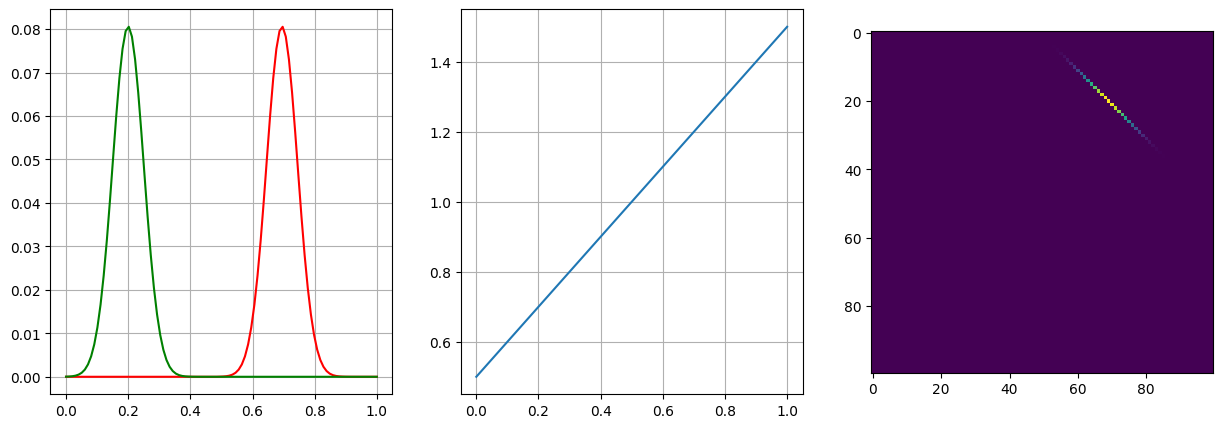

In [194]:
n = 100
x = np.linspace(0, 1, n)
mean = 0.2
std = 0.05
mu = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((x - mean)/std, 2))
mu /= mu.sum()
t = x + 0.5

# t_interp = BarycentricInterpolator(x, t)

pf = pushforward(mu, t, x)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(x, pf, c='r')
axs[0].plot(x, mu, c='g')
axs[0].grid()
axs[1].plot(x, t)
# axs[1].plot(x, t_interp(x))
axs[1].grid()


T = np.zeros((n, n))
for i, val in enumerate(t):
    j = np.argmin(np.abs(x - val))
    if mu[i] != 0:
        T[i, j] = mu[i]
axs[2].imshow(T)

In [348]:
def compute_pushforward(mu, T, target_x):
    """
    Compute the pushforward of a measure mu under a transformation map T.
    
    Parameters:
    - mu: numpy array, original measure at discrete points
    - T: numpy array, transformation map applied to each point
    - target_x: numpy array, target positions where we want to evaluate the pushforward measure
    
    Returns:
    - pushforward_rho: numpy array, pushforward measure evaluated at target_x positions
    """
    # Initialize the pushforward measure array
    pushforward_rho = np.zeros_like(target_x)

    # Interpolate transformation at target positions
    for i in range(len(mu)):
        if mu[i] > 0:  # Only process non-zero masses
            # Find two nearest target indices for the transformed position T[i]
            idx = np.searchsorted(target_x, T[i], side='right')
            
            # Boundary conditions
            if idx == 0:
                pushforward_rho[0] += mu[i]
            elif idx == len(target_x):
                pushforward_rho[-1] += mu[i]
            else:
                # Linear interpolation
                left_idx = idx - 1
                right_idx = idx
                left_dist = T[i] - target_x[left_idx]
                right_dist = target_x[right_idx] - T[i]
                total_dist = target_x[right_idx] - target_x[left_idx]
                
                # Calculate weights for linear interpolation
                weight_right = left_dist / total_dist
                weight_left = right_dist / total_dist

                # Distribute mass according to weights
                pushforward_rho[left_idx] += mu[i] * weight_left
                pushforward_rho[right_idx] += mu[i] * weight_right

    # print('computed pushforward', pushforward_rho)
    pushforward_rho /= pushforward_rho.sum() / mu.sum()
    return pushforward_rho


def pushforward(mu: np.ndarray, T: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Transforms the measure mu using the multidimensional transport map T.

    :param mu: numpy array representing the original measure (discrete densities or probabilities)
    :param T: numpy array where each row represents the new multidimensional position of each corresponding element in mu
    :return: numpy array of the transformed measure
    """
    # nu = T.T @ mu
    # nu /= nu.sum()
    # nu = sampling_pushforward_1d(mu, T, x)
    nu = compute_pushforward(mu, T, x)
    return nu

mu.sum()=1.0
pf.sum()=1.0


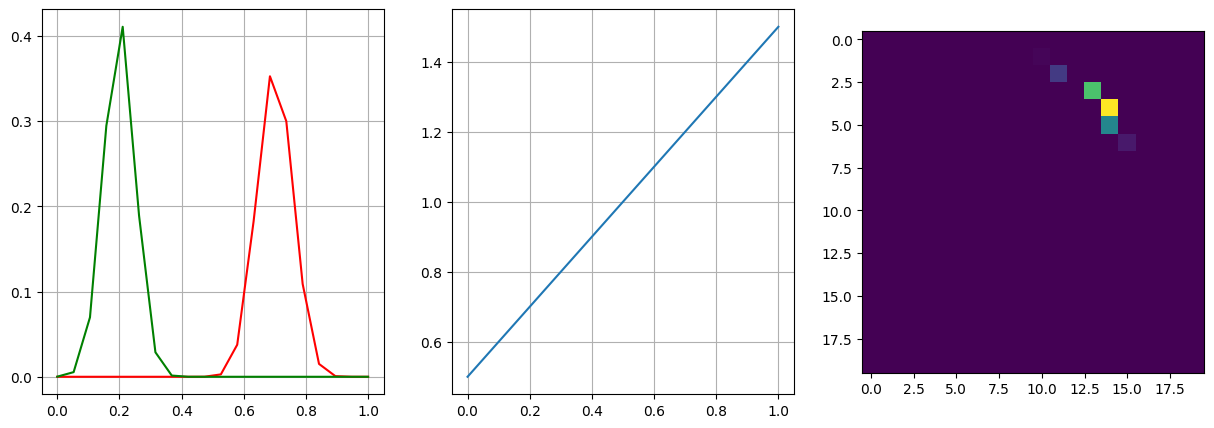

In [350]:
n = 20
x = np.linspace(0, 1, n)
mean = 0.2
std = 0.05
mu = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((x - mean)/std, 2))
mu /= mu.sum()
t = x + 0.5

# t_interp = BarycentricInterpolator(x, t)

pf = pushforward(mu, t, x)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(x, pf, c='r')
axs[0].plot(x, mu, c='g')
axs[0].grid()
axs[1].plot(x, t)
# axs[1].plot(x, t_interp(x))
axs[1].grid()


T = np.zeros((n, n))
for i, val in enumerate(t):
    j = np.argmin(np.abs(x - val))
    if mu[i] != 0:
        T[i, j] = mu[i]
axs[2].imshow(T)

print(f"{mu.sum()=}")
print(f"{pf.sum()=}")

In [351]:
def solve_pde(f, L, N):
    """
    Solves the Poisson equation -∆phi = f with Neumann boundary conditions
    using the Discrete Cosine Transform.

    Parameters:
    f : ndarray
        The source term of the Poisson equation.
    L : float
        The length of the domain.
    N : int
        The number of discretization points.

    Returns:
    x : ndarray
        The discretized domain.
    phi : ndarray
        The solution of the Poisson equation.
    """
    # Compute the discrete cosine transform of f
    f_hat = dct(f, norm='ortho')
    # Create an array of wave numbers (avoid division by zero for k=0)
    k = np.pi * np.arange(N) / L
    k[0] = 1  # avoid division by zero; will set phi_hat[0] to zero later
    # Compute the solution in the spectral domain
    phi_hat = f_hat / (k**2)
    # Set the zero-frequency component to zero
    phi_hat[0] = 0
    # Compute the inverse discrete cosine transform to get the spatial solution
    phi = idct(phi_hat, norm='ortho')
    return phi


In [352]:
def gradient(nu: np.ndarray, t_mu: np.ndarray, x: np.ndarray):
    # f = nu - t_mu
    f = t_mu - nu
    L = x[-1]
    phi = solve_pde(f, L, x.size)
    return phi


In [353]:
def compute_dual(phi: np.ndarray, psi: np.ndarray, mu: np.ndarray,
                 nu: np.ndarray, x: np.ndarray, y: np.ndarray):
    n = phi.size
    return np.sum(0.5 * (x*x+y*y) * (mu + nu) - nu*phi - mu*psi)/(n)


def stepsize_update(sigma, value, oldValue, gradSq):
    diff = value - oldValue
    scaleDown = 0.95
    scaleUp = 1/scaleDown
    upper = 0.75
    lower = 0.25

    if diff > gradSq * sigma * upper:
        return sigma * scaleUp
    elif diff < gradSq * sigma * lower:
        return sigma * scaleDown
    return sigma


def back_and_forth(
        x: np.ndarray,
        y: np.ndarray,
        mu: np.ndarray,
        nu: np.ndarray,
        cost: np.ndarray,
        cost_name: str,
        sigma: float = 0.01,
        iterations: int = 20,
        accuracy: float = 1e-10,
):
    phi = -np.ones_like(x)
    psi = -np.ones_like(y)
    n, m = x.size, y.size

    rho = np.copy(mu)
    oldValue = compute_dual(phi, psi, mu, nu, x, y)
    h1err_history = np.empty((1, 1))
    dual_history = np.empty((1, 1))
    mu_history = np.copy(mu)[np.newaxis, :]
    nu_history = np.empty((1, m))

    with tqdm(range(iterations)) as pbar:
        for i in pbar:
            rho = pushforward(
                mu,
                map_T(phi, cost_name, y, C=cost),
                x
            )
            phi_grad = gradient(
                nu,
                rho,
                x,
            )
            phi += sigma * phi_grad

            # h1_error = np.sum(np.abs(phi_grad) * rho) / n
            h1_error = np.sum(phi_grad * (rho - nu)) / n

            psi = ctransform(phi, cost)
            phi = ctransform(psi, cost)

            value = compute_dual(phi, psi, mu, nu, x, y)
            sigma = stepsize_update(sigma, value, oldValue, h1_error)
            oldValue = value

            # for animations store nu
            nu_history = np.append(nu_history, rho)

            rho = pushforward(
                nu,
                map_T(psi, cost_name, x, C=cost),
                y
            )
            psi_grad = gradient(
                mu,
                rho,
                y,
            )
            psi += sigma * psi_grad

            # h1_error = np.sum(np.abs(psi_grad) * rho) / n
            h1_error = np.sum(psi_grad * (rho - mu)) / n

            phi = ctransform(psi, cost.T)
            psi = ctransform(phi, cost)

            value = compute_dual(phi, psi, mu, nu, x, y)
            sigma = stepsize_update(sigma, value, oldValue, h1_error)
            oldValue = value

            mu_history = np.vstack([mu_history, rho])

            h1err_history = np.append(h1err_history, h1_error)
            dual_history = np.append(dual_history, value)

            pbar.set_postfix(h1=h1_error)
            if accuracy > h1_error:
                print(f"Attained needed error of {h1_error}")
                return phi, psi, h1err_history, dual_history, mu_history, nu_history

    return phi, psi, h1err_history, dual_history, mu_history, nu_history


# Examples

In [354]:
def generate_gaussian_distribution(
        num_points, mean, std, range_min, range_max
):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(
        -1/2 * np.power((grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

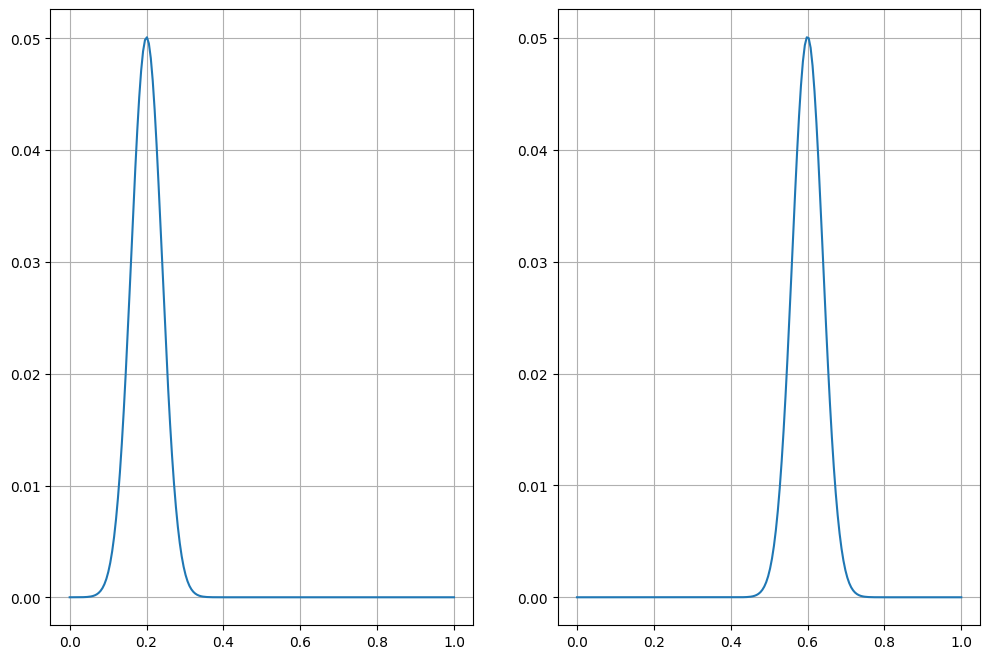

In [355]:
n = 200
std = 0.08
range_min = 0
range_max = 1

x = np.linspace(range_min, range_max, n)
y = np.linspace(range_min, range_max, n)
X, Y = np.meshgrid(x, y, indexing='ij')

_, mu = generate_gaussian_distribution(
    n, 0.2, std=0.04, range_min=range_min, range_max=range_max)
_, nu = generate_gaussian_distribution(
    n, 0.6, std=0.04, range_min=range_min, range_max=range_max)

fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].plot(x, mu)
axs[0].grid()
axs[1].plot(y, nu)
axs[1].grid()

Text(0.5, 1.0, 'Cost matrix $\\frac{1}{2}(x-y)^{2}$ of Primal Problem')

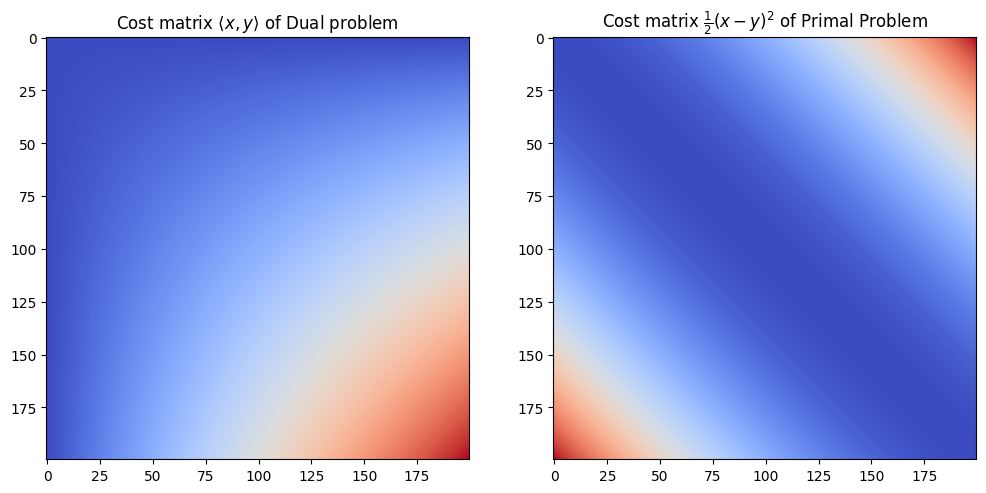

In [356]:
c = X * Y
cost = np.power(X - Y, 2) / 2
c_name = 'quadratic'

fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].imshow(c, cmap='coolwarm')
axs[0].set_title('Cost matrix $\\left<x, y\\right>$ of Dual problem')
axs[1].imshow(cost, cmap='coolwarm')
axs[1].set_title('Cost matrix $\\frac{1}{2}(x-y)^{2}$ of Primal Problem')

In [357]:
# sigma_init = 8 * np.minimum(mu.max(), nu.max())
sigma_init = 0.1
phi, psi, err1, duals, mus, nus = back_and_forth(
    x, y, mu, nu, c, c_name, sigma=sigma_init, iterations=2000, accuracy=1e-14)


100%|██████████| 2000/2000 [00:11<00:00, 174.86it/s, h1=3.33e-11]


Text(0.5, 1.0, '$\\psi$')

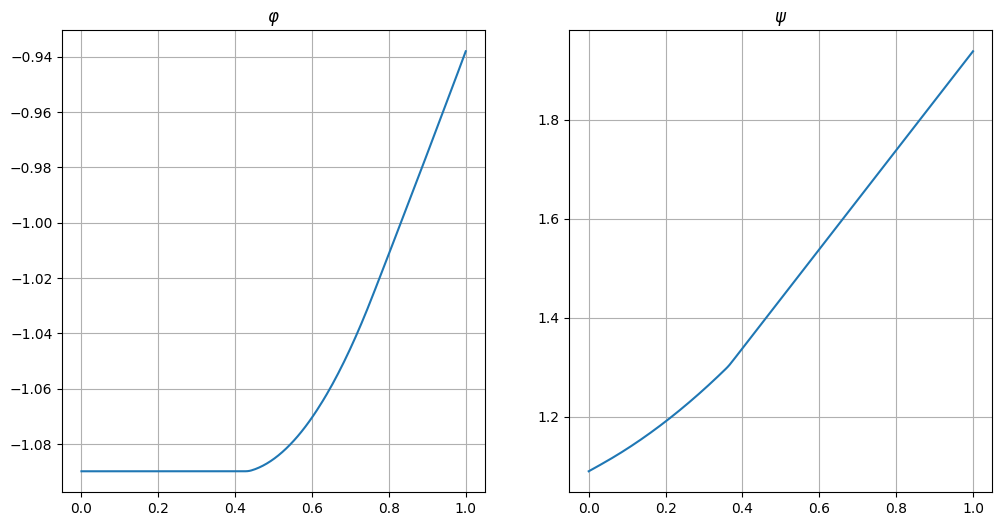

In [358]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].plot(x, phi)
axs[0].grid()
axs[0].set_title('$\\varphi$')
axs[1].plot(y, psi)
axs[1].grid()
axs[1].set_title('$\\psi$')

In [359]:
rho1 = pushforward(mu, map_T(phi, c_name, x, C=c), x)

rho2 = pushforward(nu, map_T(psi, c_name, y, C=c), y)

T_psi = map_T(psi, c_name, x, C=c)
T_phi = map_T(phi, c_name, x, C=c)
T = np.zeros((n, n))
for i, val in enumerate(T_psi):
    j = np.argmin(np.abs(y - val))
    if rho1[i] != 0 and rho2[j] != 0:
        T[i, j] = rho1[i]


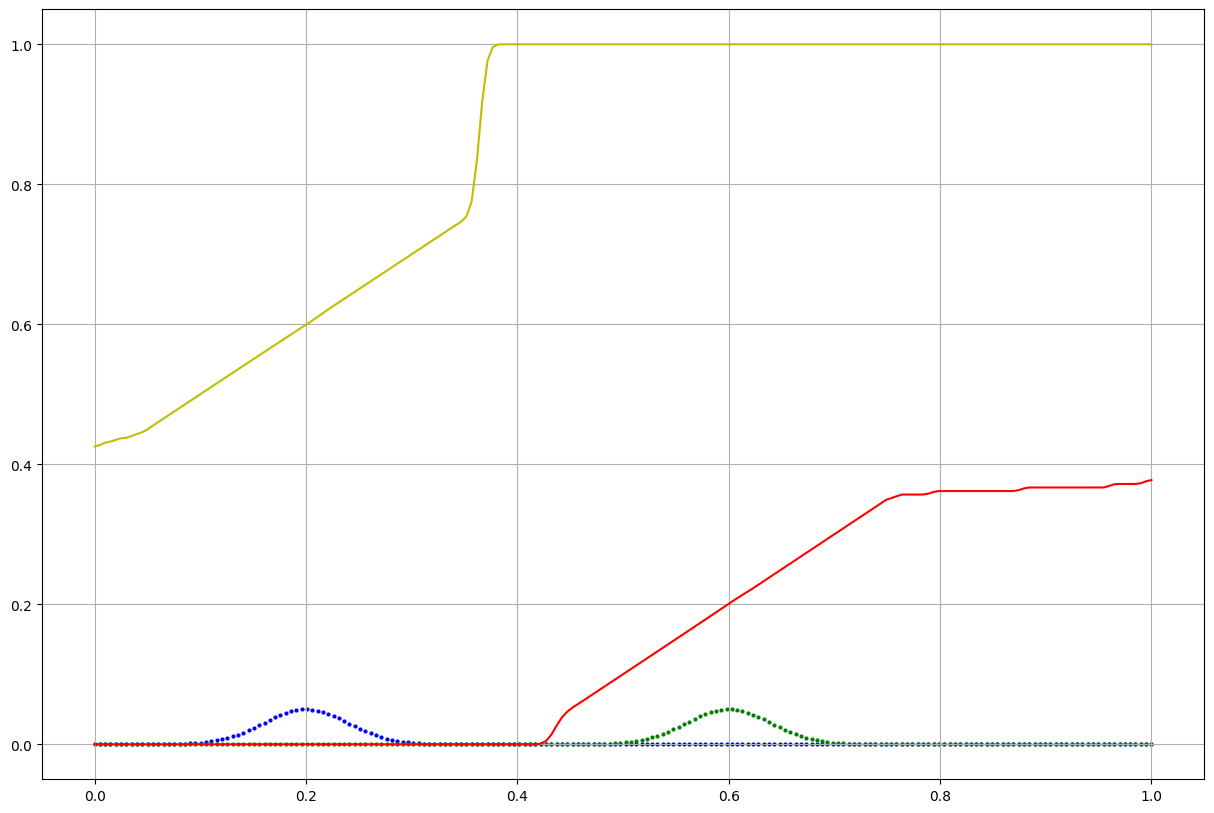

In [360]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.plot(x, T_psi, 'r')
axs.plot(y, T_phi, 'y')
axs.scatter(x, mu, c='b', s=4)
axs.scatter(y, nu, c='g', s=4)
axs.grid()

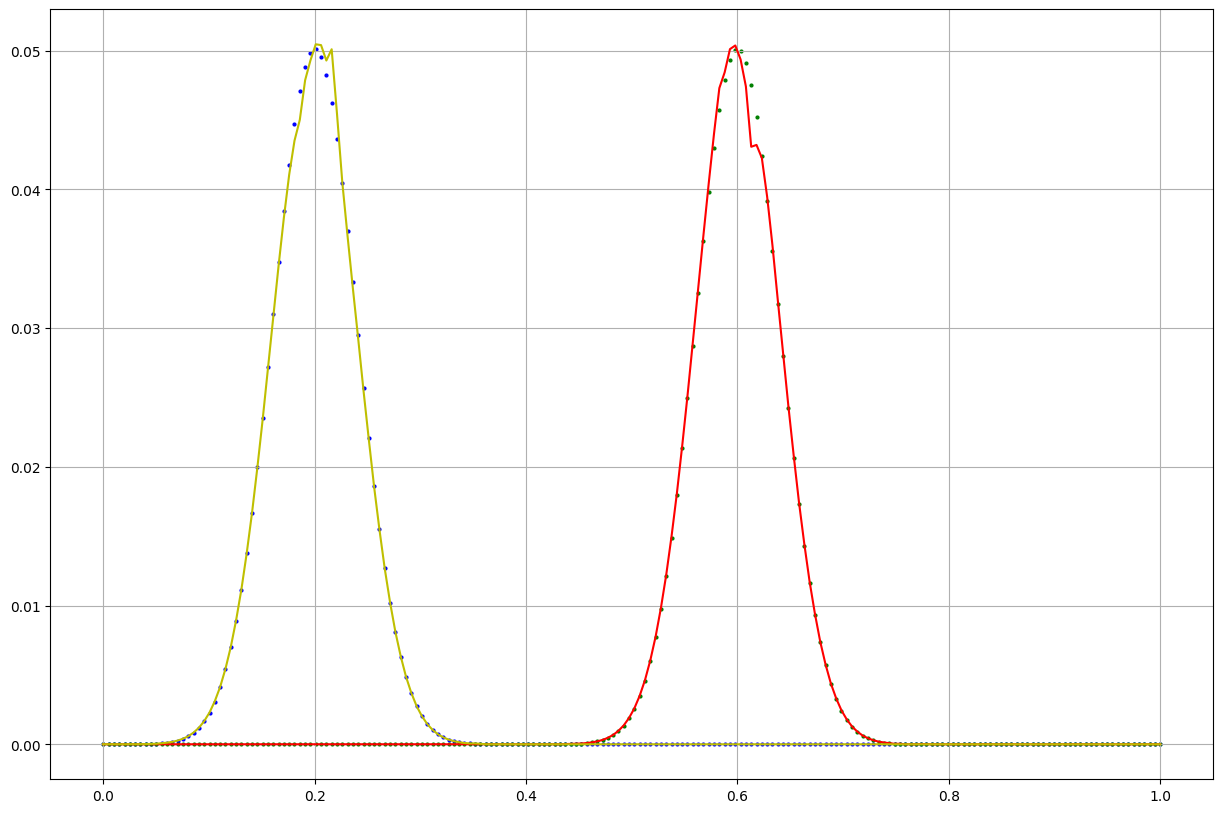

In [361]:
fig, axs = plt.subplots(1, 1, figsize=(15,10))
axs.plot(x, rho1, 'r')
axs.plot(y, rho2, 'y')
axs.scatter(x, mu, c='b', s=4)
axs.scatter(y, nu, c='g', s=4)
axs.grid()

W1 T_phi mu: 0.07993543204499341
W1 T_psi nu: 0.07993180140964157
W1 mu nu: 0.08000301320000602
W1 T_phimu T_psinu: 0.07986429472640151
EMD is done in 0.010120391845703125.


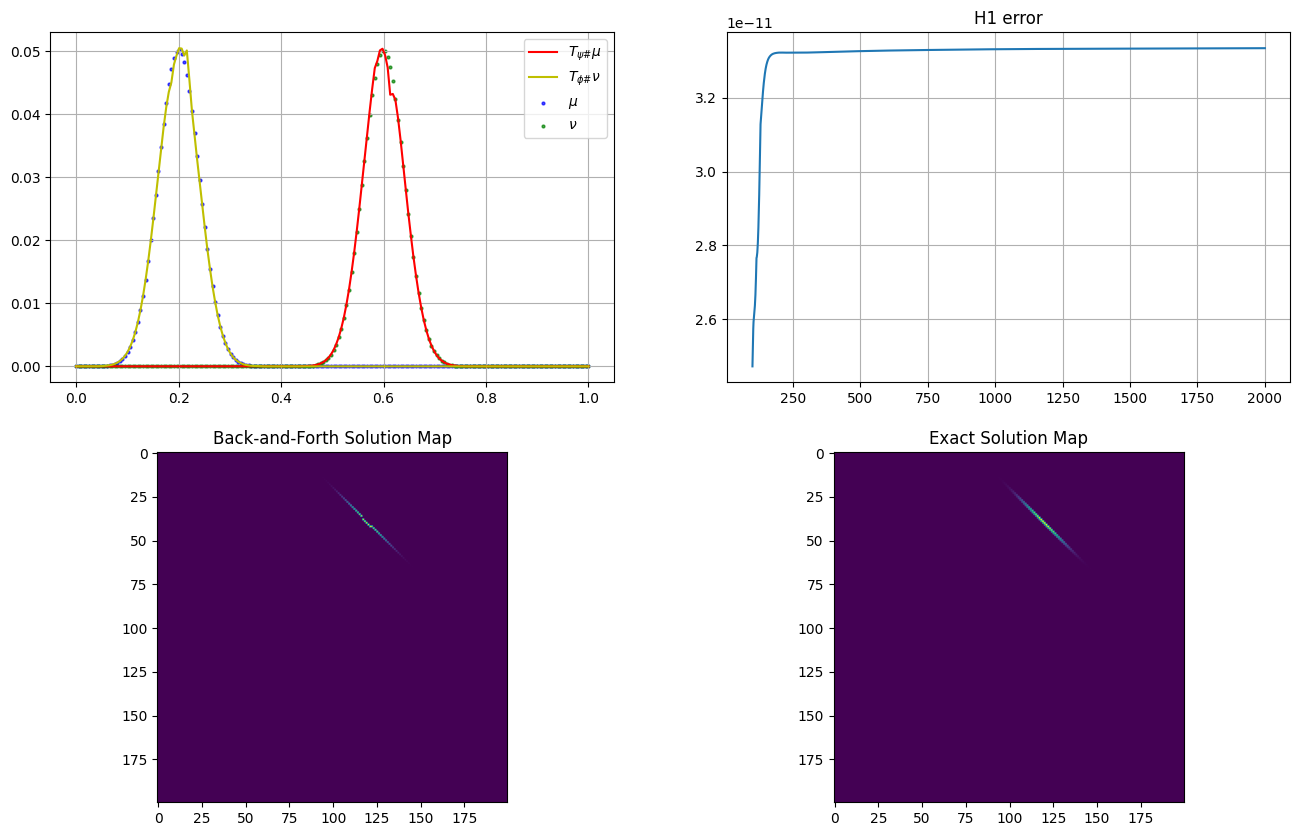

In [362]:
wasserstein_dist1 = ot.emd2(rho1, mu, cost)
wasserstein_dist2 = ot.emd2(rho2, nu, cost)
print(f"W1 T_phi mu: {wasserstein_dist1}")
print(f"W1 T_psi nu: {wasserstein_dist2}")

wasserstein_dist_mu_nu = ot.emd2(mu, nu, cost)
print(f"W1 mu nu: {wasserstein_dist_mu_nu}")

wasserstein_dist_phi_psi = ot.emd2(rho1, rho2, cost)
print(f"W1 T_phimu T_psinu: {wasserstein_dist_phi_psi}")

exact_start = time.time()
exact_sol = ot.emd(mu, nu, cost)
print(f"EMD is done in {time.time() - exact_start}.")

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0][0].plot(y, rho1, 'r', label='$T_{\\psi \\#}\\mu$')
axs[0][0].plot(y, rho2, 'y', label='$T_{\\phi \\#}\\nu$')
# axs[0].plot(grid1, T_psi, 'y', label='$T_{\\psi}$')
axs[0][0].scatter(x, mu, s=4, alpha=0.7, c='b', label='$\\mu$')
axs[0][0].scatter(y, nu, s=4, alpha=0.7, c='g', label='$\\nu$')
axs[0][0].legend()
axs[0][0].grid()

err_start = 100
axs[0][1].plot(np.arange(err_start, err1.size), err1[err_start:])
axs[0][1].set_title('H1 error')
axs[0][1].grid()

axs[1][0].imshow(T.T)
axs[1][0].set_title('Back-and-Forth Solution Map')
axs[1][1].imshow(exact_sol)
axs[1][1].set_title('Exact Solution Map')
# axs[1][1].plot(np.arange(0, duals.size), duals)
# axs[1][1].set_title('Dual values')
# fig.show()

plt.show()


In [363]:
np.abs(T.T - exact_sol).sum()

0.8979943952651508

(2000, 200)


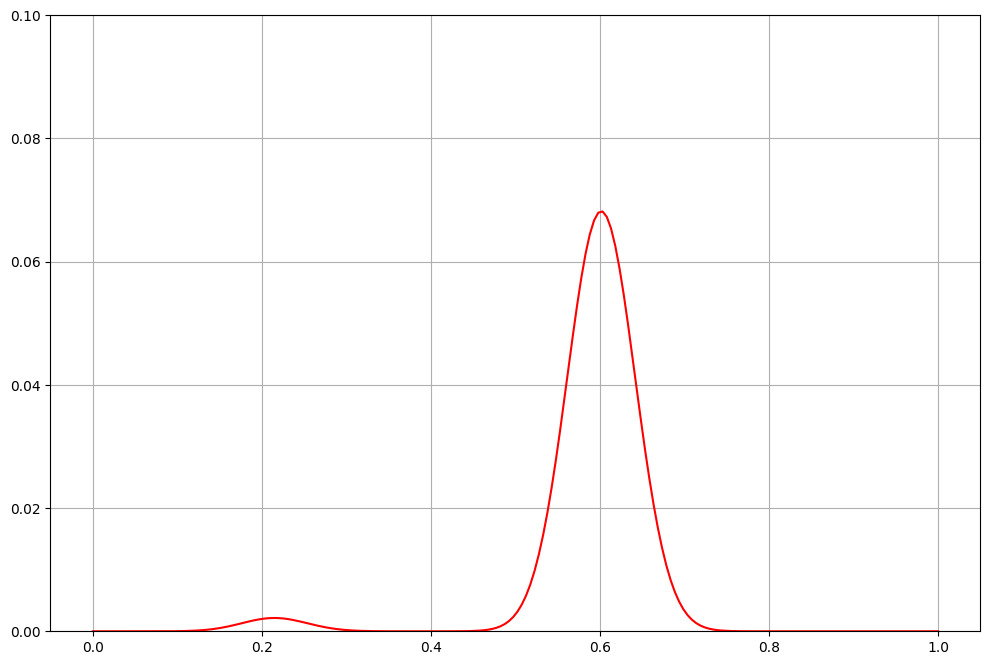

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x800', '-pix_fmt', 'rgba', '-framerate', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'measure_changes.mp4']' returned non-zero exit status 255.

In [364]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example data: (k, n) array where k is number of time steps and n is size of space
# k, n = 50, 100  # 50 time steps and 100 space size
# data = np.random.rand(k, n)  # Random data simulating the measure changes

k = 2000

data = nus.reshape((k + 1, n))[:k]

print(data.shape)

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid()
ax.set_ylim(0, 0.1)
line, = ax.plot(x, data[0], 'r-')

def update(frame):
    """
    Update the plot for each frame.
    """
    line.set_ydata(data[frame])  # Set the new data for the y-axis
    return line,

# Create an animation
ani = FuncAnimation(fig, update, frames=range(k), blit=True, interval=100)

# To show the animation in a Jupyter notebook
plt.show()

# To save the animation as an mp4 or GIF file
ani.save('measure_changes.mp4', writer='ffmpeg')  # Uncomment this line to save as MP4
# ani.save('measure_changes.gif', writer='imagemagick')  # Uncomment this line to save as GIF
